# STAT 201 Project Final Report Group 20



Group members:
<br>Alan Zhang 
<br>Sneh Agarwal
<br>Taniya Cai
<br>Waxin Luo

### Introduction

Recently, bike-sharing systems have increasing popularity as a means of efficient transportation in urban areas. These systems are not only a feasible solution to the world’s major environmental problems, but they also play an important role in traffic and health issues. Its users are able to rent a bicycle from a convenient depot location, and return it at another one close to the user's destination. In the U.S. alone, over 60 cities have integrated bike-sharing systems and in densely populated cities like New York, the count of cyclists can reach 10,000 per day (Walker, 2019).The ubiquity of such programs has therefore generated investigation and analysis of quantifiable data for further effectiveness. Capital Bikeshare is one such bike-sharing system, that serves the Washington D.C. metropolitan area, and publishes yearly anonymized statistics, including the daily usage times (Capital Bikeshare). 

Better estimations of traffic flow under various conditions will enable bike-sharing companies to make more appropriate decisions on dispatching bikes thus maximizing bike-sharing availability and efficiency. Previous studies suggest that weather conditions have significant impacts on bike-share frequencies and fluctuation, and among various quantitative factors that define weather, the temperature is undoubtedly the most commonly used and analyzed (Gebhart & Noland, 2014).

Washington D.C. has a dynamic temperature range, where the hot season can reach over 30 degrees celsius and the cold season can drop to below 0 degrees celsius (Weather Spark). Both the hot and cold season can last over 3 months, which provide extensive room for the application of different data analysis methods that require reproducible information.
​
The particular parameter of interest is the normalized frequency of users during different temperatures and days for bike-sharing systems. This would gauge demand, and so would be useful for possible seasonal or monthly availability decisions. The scale parameter of interest is standard deviation as it is representative of the degree of fluctuation in bike availability of the system (Institute for Operations Research and the Management Sciences, 2020). 

Since it is more likely to have casual users in warmer weather, it is hypothesized that both the fluctuation and the average count of rental bikes will decrease in the cold season, hence we are expecting to see that the average and standard deviation of the number of bike shares in the mild season (spring) to be larger than a cold season (winter).

### Methods and Results

In [14]:
library(repr)
library(tidyverse)
library(dplyr)
library(grid)
library(infer)

The first step is to download the dataset zip file from the website, unzip the files, and load the dataset into R. We name the dataset as bike.

In [15]:
dir.create("data")
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
download.file(url,"data/Bike-Sharing-Dataset.zip")
unzip("data/Bike-Sharing-Dataset.zip", files="day.csv", exdir="data/")
bike <- read_csv("data/day.csv") 
head(bike)
print("Table 1")

Warning message in dir.create("data"):
“'data' already exists”
Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


[1] "Table 1"


Table 1 features part of the original dataset. Since season is a appropriate generalization of factors such as temperature, it is a feasible choice to use to determine our preliminary results. 

In [16]:
bike <- bike %>%
 select(season, cnt)
print("Table 2 Cleaned bike dataset")
head(bike)

[1] "Table 2 Cleaned bike dataset"


season,cnt
<dbl>,<dbl>
1,985
1,801
1,1349
1,1562
1,1600
1,1606


Season is represented incorrectly as a numerical variable in table 2 so we changed it to a categorical variable. 

In [17]:
bike$season <- as.factor(bike$season)

Although we have specified to use mean and standard deviation as parameters of interest, for preliminary analysis we think that it is more visually effective to use side-by-side boxplots to compare distributions among categorical variables.

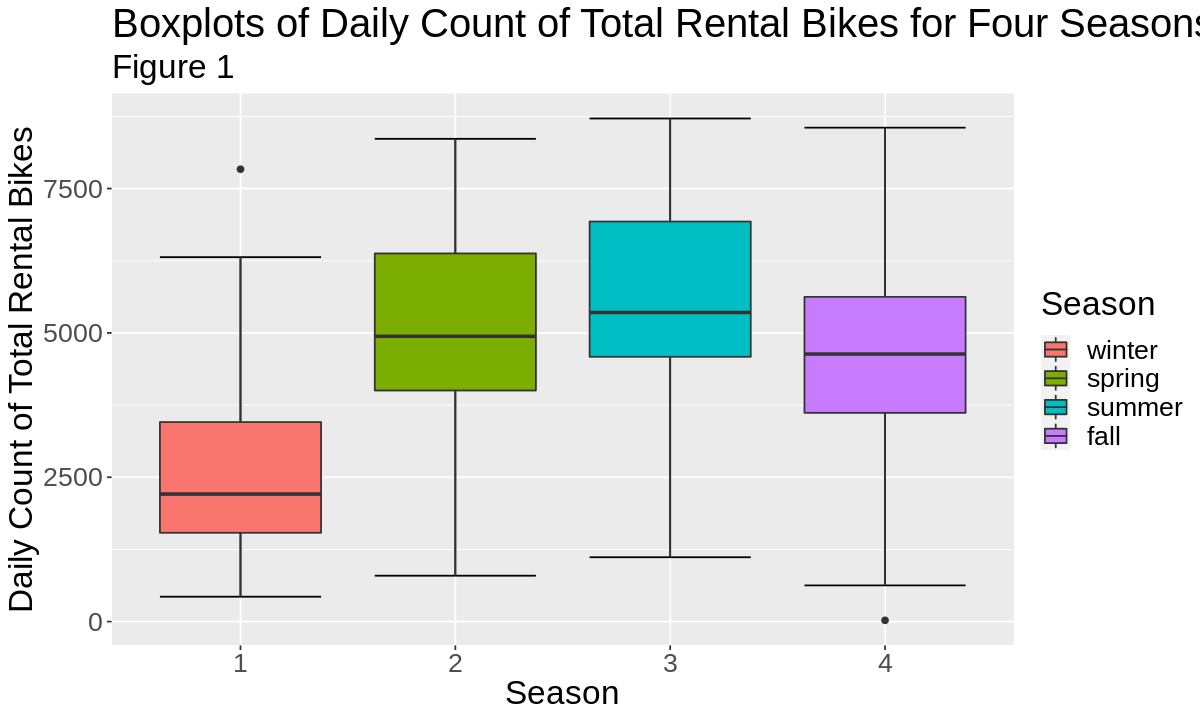

In [18]:
boxplots <- bike %>%  
          ggplot(aes(x = season, y = cnt, fill = season)) + 
          stat_boxplot(geom ='errorbar') + 
          geom_boxplot() + 
          labs(x = "Season", y = "Daily Count of Total Rental Bikes", 
               title = "Boxplots of Daily Count of Total Rental Bikes for Four Seasons",
               subtitle = "Figure 1") +
          theme(text = element_text(size=20)) +
          scale_fill_discrete(name = "Season", labels = c("winter", "spring", "summer", "fall"))
options(repr.plot.height = 6, repr.plot.width = 10)
boxplots

In [19]:
bike_summary <- bike %>% 
     group_by(season) %>% 
     summarize(n = n(), Average_Count = mean(cnt), Median_Count = median(cnt), Standard_Dev = sd(cnt),
               IQR = quantile(cnt, 0.75) - quantile(cnt, 0.25), min = min(cnt), max = max(cnt))
print("Table 3 Preliminary results")
bike_summary

[1] "Table 3 Preliminary results"


season,n,Average_Count,Median_Count,Standard_Dev,IQR,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,181,2604.133,2209.0,1399.942,1918.00,431,7836
2,184,4992.332,4941.5,1695.977,2374.00,795,8362
3,188,5644.303,5353.5,1459.800,2342.75,1115,8714
4,178,4728.163,4634.5,1699.615,2009.00,22,8555


Table 3 provides an exhaustive list of summary statistics of the daily cont for four seasons. We included our parameters of interest (standard deviation)as well as other statistics that maybe helpful in better understanding the preliminary results. It can be observed that preliminary analysis supports our hypothesis of larger standard deviation in milder seasons (spring-2 and fall-4).

We decided to transform the dataset to have two distinct season, where spring counts will be represented as "mild" and winter counts will be represented as "cold". 

In [20]:
bike$season <- as.character(bike$season)      # convert factor to character
bike$season[bike$season == "1"] <- "cold"
bike$season[bike$season == "2"] <- "mild" 
bike$season <- as.factor(bike$season)         # convert back to factor
bike_reduced <- bike %>%
    filter(season == "cold" | season == "mild")
print("Table 4 Reduced bike dataset")
head(bike_reduced)

[1] "Table 4 Reduced bike dataset"


season,cnt
<fct>,<dbl>
cold,985
cold,801
cold,1349
cold,1562
cold,1600
cold,1606


Now we will take a look of the reduced data

In [21]:
bike_summary <- bike_reduced %>% 
    group_by(season) %>% 
    summarize(n = n(), count_median = median(cnt), count_average = mean(cnt), sd = sd(cnt),
             IQR = quantile(cnt, 0.75) - quantile(cnt, 0.25), min = min(cnt), max = max(cnt))
print("Table 5 Summary statistics of reduced data")
bike_summary

[1] "Table 5 Summary statistics of reduced data"


season,n,count_median,count_average,sd,IQR,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cold,181,2209.0,2604.133,1399.942,1918,431,7836
mild,184,4941.5,4992.332,1695.977,2374,795,8362


The data is cleaned and wrangled with no missing values and of a sufficient and comparable sample size, which suggest that it is representative of our population and our explanatory variable season.

#### Bootstrapping VS. Asymptotic Analysis

The CLT states that for sufficiently large samples with n >= 30, the sampling distribution of sample means will tend towards a normal distribution regardless of the original distribution of the population. In the dataset, both samples are of sufficient size hence we can use CLT to approximate the sampling distribution of sample means through taking multiple samples of both groups and calculated their means.

To visualized the comparison, we use histograms to show the distribution of our data:

In [31]:
options(repr.plot.height = 6, repr.plot.width = 10)

overlayed_distribution <- bike_reduced %>% 
    ggplot(aes(x = cnt, fill = season)) +
    scale_fill_discrete(name = "Season", values = c("cold" = "blue", "mild" = "green"))+
    geom_histogram(position = "identity", binwidth = 600, alpha = 0.6) +
    labs(x = "Number of Bike Rentals", y = "Count", 
         title = "Sample Distribution of Bike Share Counts by Season",
         subtitle = "Figure 2") +
    theme(text = element_text(size = 20)) + 
    geom_vline(aes(xintercept = bike_summary$count_average[1], color = "cold"), size = 1.7) +
    geom_vline(aes(xintercept = bike_summary$count_average[2], color = "mild"), size = 1.7) +
    scale_color_manual(name = "Mean", values = c("cold" = "blue", "mild" = "green"))

overlayed_distribution

ERROR: Error in discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, direction), : unused argument (values = c("blue", "green"))


##### Hypothesis for location parameter (mean):

$H_{0}$ : The mean count of bike rentals of cold season is the same as the mean count of bike rentals of mild season.

$H_{A}$ : The mean count of bike rentals of cold season less than the mean count of bike rentals of mild season.

##### Hypothesis for scale parameter (standard deviation):

$H_{0}$ : The standard deviation of bike rentals of cold season is the same as the standard deviation count of bike rentals of mild season.

$H_{A}$ : The standard deviation of bike rentals of cold season is less than the standard deviation count of bike rentals of mild season.

#### Applying the Large Sample Theory for Location Parameter (Mean)

Since we have justify that CLT is applicable to our dataset it is appropriate to use the two-sample t-test to compare the means of the two season. Here since we expect the standard deviation (hence also variance) of the two groups to be different, we will be using Welch Two Sample t-test where it is assumed that the variances are unequal.

In [23]:
cold_counts <- bike_reduced %>%
  filter(season == "cold") %>%
  pull(cnt)
mild_counts <- bike_reduced %>%
  filter(season == "mild") %>%
  pull(cnt)
diff_in_mean_stat <- t.test(cold_counts, mild_counts, alternative = "less", var.equal = FALSE)      # conducting unpaired two sample t-test with unequal variances
p_value_t_mean <- tibble(p_value. = diff_in_mean_stat$p.value)
print("Table 6 Summary statistics for t-test")
diff_in_mean_stat
print("Table 7 p-value for mean through t-test")
p_value_t_mean

[1] "Table 6 Summary statistics for t-test"



	Welch Two Sample t-test

data:  cold_counts and mild_counts
t = -14.682, df = 352.41, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -2119.933
sample estimates:
mean of x mean of y 
 2604.133  4992.332 


[1] "Table 7 p-value for mean through t-test"


p_value.
<dbl>
1.031277e-38


#### Bootstrapping Analysis for Location Parameter (Mean)

We set a seed to make sure our result is reproducible and take 1000 Bootstrap samples to create an approximation of the sampling distribution, and produce a table of summary statistics and visualization.

Dropping unused factor levels c("3", "4") from the supplied explanatory variable 'season'.



[1] "Table 8 Summary statistics of bootstrapping for mean"


median,mean,standard_deviation
<dbl>,<dbl>,<dbl>
2390.694,2394.825,164.1392


[1] "Table 9 95% confidence interval of bootstrapping result for mean"


lower_ci,upper_ci
<dbl>,<dbl>
2072.236,2708.195


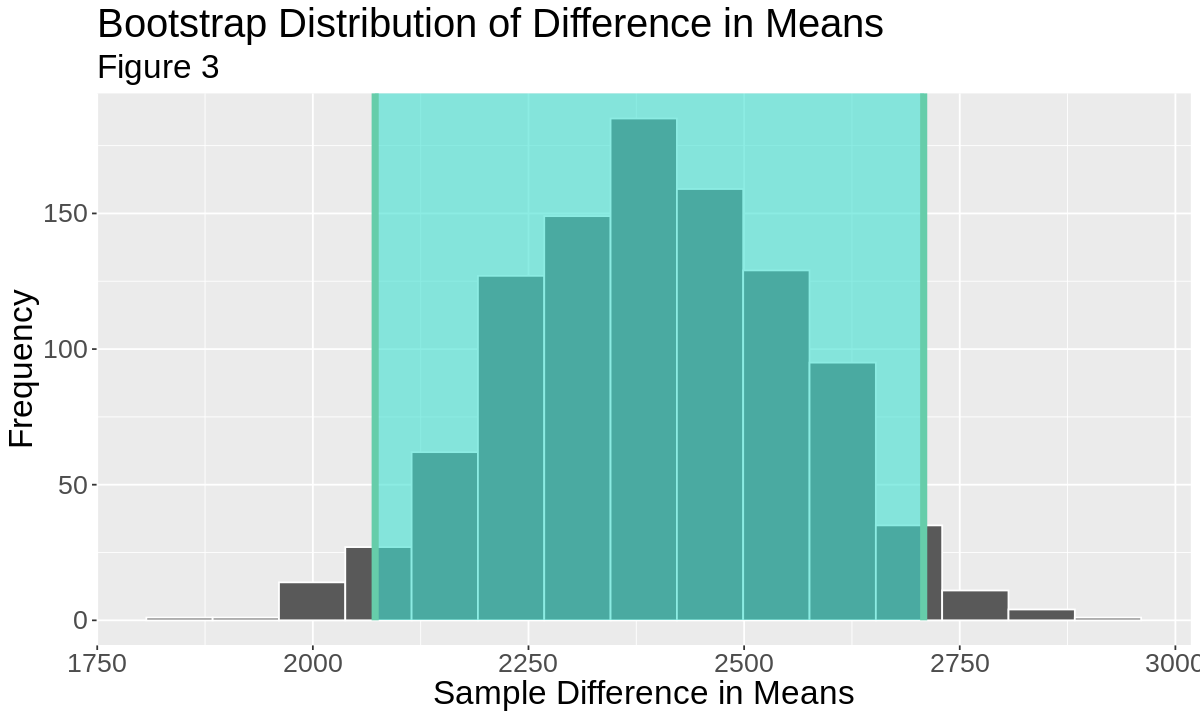

In [24]:
set.seed(1234)

bootstrap_dist = bike_reduced %>% 
    specify(formula = cnt ~ season) %>% 
    generate(reps = 1000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("mild", "cold"))

bootstrap_ci = bootstrap_dist %>% 
    get_ci(0.95, type = "percentile")

bootstrap_summary <- bootstrap_dist %>% 
    summarise(median = median(stat), mean = mean(stat), standard_deviation = sd(stat))

print("Table 8 Summary statistics of bootstrapping for mean")
bootstrap_summary
print("Table 9 95% confidence interval of bootstrapping result for mean")
bootstrap_ci

bootstrap_dist_graph <- visualize(bootstrap_dist) + 
    shade_ci(endpoints = bootstrap_ci) + 
    labs(x = "Sample Difference in Means", y = "Frequency", 
         title = "Bootstrap Distribution of Difference in Means",subtitle = "Figure 3") + 
    theme(text = element_text(size = 20))

bootstrap_dist_graph

We can now use the bootstrap distribution to test against the null hypothesis and produce the p-value.

In [25]:
set.seed(1234)

diff_in_mean_null_dist <- bike_reduced %>%
    specify(formula = cnt ~ season) %>% 
    hypothesise(mu  = 0, null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("mild", "cold"))

p_value_mean <- get_p_value(diff_in_mean_null_dist, 
                      obs_stat = bike_summary$count_average[2] - bike_summary$count_average[1], 
                      direction = "both")

bootstrap_ci <- diff_in_mean_null_dist %>% 
    get_ci(0.95, type = "percentile")

print("Table 10 P-value for mean")
p_value_mean
print("Table 11 95% confidence interval of hypoethesis test for mean")
bootstrap_ci

Dropping unused factor levels c("3", "4") from the supplied explanatory variable 'season'.

Warning message:
“Parameter values are not specified when testing that two variables are independent.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] "Table 10 P-value for mean"


p_value
<dbl>
0


[1] "Table 11 95% confidence interval of hypoethesis test for mean"


lower_ci,upper_ci
<dbl>,<dbl>
-394.7946,391.7279


#### Analysis for Scale Parameter (Standard Deviation)

Since we are interested in comparing the difference in standard deviation of the two groups, the most appropriate test would be an one-sided F-test for difference in variance.

In [26]:
diff_in_sd_stat <- var.test(cnt ~ season, bike_reduced, 
         alternative = "less")
print("Table 12 F-test statistics for standard deviation")
diff_in_sd_stat
p_value_sd <- tibble(p_value. = diff_in_sd_stat$p.value)
print("Table 13 p-value for standard deviation")
p_value_sd

[1] "Table 12 F-test statistics for standard deviation"



	F test to compare two variances

data:  cnt by season
F = 0.68137, num df = 180, denom df = 183, p-value = 0.005069
alternative hypothesis: true ratio of variances is less than 1
95 percent confidence interval:
 0.0000000 0.8705077
sample estimates:
ratio of variances 
         0.6813655 


[1] "Table 13 p-value for standard deviation"


p_value.
<dbl>
0.005068686


### Discussion

In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

Summarize what you found, and the implications/impact of your findings.

If relevant, discuss whether your results were what you expected to find.

Discuss future questions/research this study could lead to.

### References

Capital Bikeshare. (n.d.). The History of Capital Bikeshare. Capital Bikeshare. Retrieved March 5,
2022, from
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://ride.capitalbikeshare.com/about 

Gebhart, K., & Noland, R. B. (2014). The impact of weather conditions on bikeshare trips in Washington, DC. Transportation, 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;41(6), 1205–1225. https://doi.org/10.1007/s11116-014-9540-7

Institute for Operations Research and the Management Sciences. (2020, January 6). Maximizing bike-share ridership: New 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;research says it's all about location: 10% increase in bike-availability levels increases ridership by 12%. ScienceDaily. 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Retrieved March 4, 2022 from www.sciencedaily.com/releases/2020/01/200106141616.htm

Walker, A. (2019, December 16). How bike share became the decade's Biggest Transit Success Story. Curbed. Retrieved <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;April 4, 2022, from https://archive.curbed.com/2019/12/16/20864145/bike-share-citi-bike-jump-uber

Weather Spark. (n.d.). Climate and Average Weather Year Round in Washington, D.C. weatherspark.com. Retrieved April 4, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2022, from https://weatherspark.com/y/20957/Average-Weather-in-Washington-D.C.;-United-States-Year-Round